## 导库

In [1]:
import os, argparse, time, datetime, sys, shutil, stat, torch
import torchvision.models as models
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from util.MF_dataset import MF_dataset
from util.util import compute_results, visualize
from sklearn.metrics import confusion_matrix
from scipy.io import savemat
import torch.nn.functional as F
import numpy as np
from PIL import Image
from util.augmentation import RandomFlip, RandomCrop, RandomCropOut, RandomBrightness, RandomNoise
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet152_Weights, ResNet50_Weights

## 模型搭建

### 注意力机制

In [2]:
class AttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attetion = nn.Sequential(
            nn.Conv2d(channels * 2, channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels // 2),
            nn.ReLU(),
            nn.Conv2d(channels // 2, 2, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        self.rgb_confidence = nn.Parameter(torch.tensor(1.0))
        self.thermal_confidence = nn.Parameter(torch.tensor(1.0))  # 权重更新动量系数

    def update(self, rgb_purity, thermal_purity):
        self.rgb_prior = self.momentum * self.rgb_prior + (1-self.momentum)* rgb_purity
        self.thermal_prior = self.momentum * self.thermal_prior + (1-self.momentum) * thermal_purity
        self.rgb_prior.data.clamp_(0.1, 1.0)
        self.thermal_prior.data.clamp_(0.1, 1.0)

    def forward(self, rgb_feat, thermal_feat):
        combined = torch.cat([rgb_feat, thermal_feat], dim=1)
        attention_weights = self.attention(combined)  # [B,2,H,W]

        # 将置信度参数转换为与attention_weights相同的维度
        rgb_conf = torch.sigmoid(self.rgb_confidence).view(1,1,1,1)  # [1,1,1,1]
        thermal_conf = torch.sigmoid(self.thermal_confidence).view(1,1,1,1)

        # 动态调整权重（关键修改点）
        adjusted_weights = torch.cat([
            attention_weights[:,0:1] * rgb_conf * self.rgb_prior,
            attention_weights[:,1:2] * thermal_conf * self.thermal_prior
        ], dim=1)

        # 重新归一化
        norm_weights = adjusted_weights / (adjusted_weights.sum(dim=1, keepdim=True) + 1e-8)

        return rgb_feat * norm_weights[:,0:1] + thermal_feat * norm_weights[:,1:2]

### 信息瓶颈

In [3]:
class TransBottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=1, upsample=None):
        super(TransBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if upsample is not None and stride != 1:
            self.conv3 = nn.ConvTranspose2d(planes, planes, kernel_size=2, stride=stride, padding=0, bias=False)
        else:
            self.conv3 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):  # 残差连接
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            residual = self.upsample(x)

        out += residual
        out = self.relu(out)

        return out

### 网络定义

In [4]:
class RTFNet(nn.Module):
    # 初始化
    def __init__(self, n_class):
        super().__init__()
        self.num_resnet_layers = 152

        if self.num_resnet_layers == 50:
            resnet_raw_model1 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            resnet_raw_model2 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.inplanes = 2048
        elif self.num_resnet_layers == 152:
            resnet_raw_model1 = models.resnet152(weights=ResNet152_Weights.DEFAULT)
            resnet_raw_model2 = models.resnet152(weights=ResNet152_Weights.DEFAULT)
            self.inplanes = 2048

        # 基础层
        self.encoder_thermal_bn1 = resnet_raw_model1.bn1
        self.encoder_thermal_relu = resnet_raw_model1.relu
        self.encoder_thermal_pool = resnet_raw_model1.maxpool
        self.encoder_rgb_bn1 = resnet_raw_model2.bn1
        self.encoder_rgb_relu = resnet_raw_model2.relu
        self.encoder_rgb_pool = resnet_raw_model2.maxpool
        # 编码器
        # Thermal & RGB 第一层
        self.encoder_thermal_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_thermal_conv1.weight.data = torch.unsqueeze(torch.mean(resnet_raw_model1.conv1.weight.data, dim=1), dim=1)
        self.encoder_rgb_conv1 = resnet_raw_model2.conv1
        # Thermal & RGB 第二层
        self.encoder_thermal_layer1 = resnet_raw_model1.layer1
        self.encoder_rgb_layer1 = resnet_raw_model2.layer1
        # Thermal & RGB 第三层
        self.encoder_thermal_layer2 = resnet_raw_model1.layer2
        self.encoder_rgb_layer2 = resnet_raw_model2.layer2
        # Thermal & RGB 第四层
        self.encoder_thermal_layer3 = resnet_raw_model1.layer3
        self.encoder_rgb_layer3 = resnet_raw_model2.layer3
        # Thermal & RGB 第五层
        self.encoder_thermal_layer4 = resnet_raw_model1.layer4
        self.encoder_rgb_layer4 = resnet_raw_model2.layer4
        # 权重存储
        self.a = nn.Parameter(torch.tensor(1.0))
        self.register_buffer('a_history', torch.zeros(100))
        self.register_buffer('history_idx', torch.tensor(0))

        # 融合层 通道数待定
        # self.fusion = AttentionFusion()

        # 解码器
        self.deconv1 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2, stride=2)
        self.deconv2 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2, stride=2)
        self.deconv3 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2, stride=2)
        self.deconv4 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2, stride=2)
        self.deconv5 = self._make_transpose_layer(TransBottleneck, n_class, 2, stride=2)    

    def _make_transpose_layer(self, block, planes, blocks, stride=1):
        upsample = None
        if stride != 1:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.inplanes, planes, kernel_size=2, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        for m in upsample.modules():  
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        layers = []
        for i in range(1, blocks):
            layers.append(block(self.inplanes, self.inplanes))
        layers.append(block(self.inplanes, planes, stride, upsample))
        self.inplanes = planes

        return nn.Sequential(*layers)
    
    def forward(self, x):
        """强制子类实现forward方法"""
        pass

### 网络结构

In [5]:
class Fusion(RTFNet):
    def __init__(self, n_class):
        super().__init__(n_class)
        
    def forward(self, input):

        rgb = input[:, :3]
        thermal = input[:, 3:]

        rgb = self.encoder_rgb_conv1(rgb) # (240, 320)
        rgb = self.encoder_rgb_bn1(rgb) # (240, 320)
        rgb = self.encoder_rgb_relu(rgb) # (240, 320)

        thermal = self.encoder_thermal_conv1(thermal) # (240, 320)
        thermal = self.encoder_thermal_bn1(thermal) # (240, 320)
        thermal = self.encoder_thermal_relu(thermal) # (240, 320)
    
        fuse = rgb + thermal  # 融合一次

        rgb = self.encoder_rgb_pool(rgb) # (120, 160)
        thermal = self.encoder_thermal_pool(thermal) # (120, 160)

        rgb = self.encoder_rgb_layer1(rgb) # (120, 160)
        thermal = self.encoder_thermal_layer1(thermal) # (120, 160)

        rgb = rgb + thermal

        rgb = self.encoder_rgb_layer2(rgb) # (60, 80)
        thermal = self.encoder_thermal_layer2(thermal) # (60, 80)

        rgb = rgb + thermal

        rgb = self.encoder_rgb_layer3(rgb) # (30, 40)
        thermal = self.encoder_thermal_layer3(thermal) # (30, 40)

        rgb = rgb + thermal

        rgb = self.encoder_rgb_layer4(rgb) # (15, 20)
        thermal = self.encoder_thermal_layer4(thermal) # (15, 20)

        a = torch.sigmoid(self.a) * 2
        fuse = a * rgb + (2 - a) * thermal
        self._update_a_history(a.detach())

        fuse = self.deconv1(fuse) # (30, 40)
        fuse = self.deconv2(fuse) # (60, 80)
        fuse = self.deconv3(fuse) # (120, 160)
        fuse = self.deconv4(fuse) # (240, 320)
        fuse = self.deconv5(fuse) # (480, 640)

        return fuse

    def _update_a_history(self, a_value):
        idx = self.history_idx.item()
        self.a_history[idx] = a_value
        self.history_idx.fill_((idx + 1) % 100)

### 测试运行

In [6]:
def unit_test():
    num_minibatch = 1
    rgb = torch.randn(num_minibatch, 3, 480, 640)
    thermal = torch.randn(num_minibatch, 1, 480, 640)
    rtf_net = RTFNet(9)
    input = torch.cat((rgb, thermal), dim=1)
    rtf_net(input)
    # print('The model: ', rtf_net.modules)
    print('Accomplished！')

if __name__ == '__main__':
    unit_test()

Accomplished！


## 模型训练

In [ ]:
# parser = argparse.ArgumentParser(description='Train with pytorch')
# parser.add_argument('--model_name', '-m', type=str, default='RTFNet')
# parser.add_argument('--batch_size', '-b', type=int, default=2)
# parser.add_argument('--lr_start', '-ls', type=float, default=0.01)
# parser.add_argument('--gpu', '-g', type=int, default=0)
# parser.add_argument('--lr_decay', '-ld', type=float, default=0.95)
# parser.add_argument('--epoch_max', '-em', type=int, default=1)
# parser.add_argument('--epoch_from', '-ef', type=int, default=0)
# parser.add_argument('--num_workers', '-j', type=int, default=2)
# parser.add_argument('--n_class', '-nc', type=int, default=9)
# parser.add_argument('--data_dir', '-dr', type=str, default='./dataset/')
# args, unknown = parser.parse_known_args()

# augmentation_methods = [
#     RandomFlip(prob=0.5),
#     RandomCrop(crop_rate=0.1, prob=1.0),
#     # RandomCropOut(crop_rate=0.2, prob=1.0),
#     # RandomBrightness(bright_range=0.15, prob=0.9),
#     # RandomNoise(noise_range=5, prob=0.9),
# ]
# writer = SummaryWriter()
# def train(epo, model, train_loader, optimizer):
#     model.train()
#     for it, (images, labels, names) in enumerate(train_loader):
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         images = Variable(images).to(device)
#         labels = Variable(labels).to(device)
#         start_t = time.time() # time.time() returns the current time
#         optimizer.zero_grad()
#         logits = model(images)
#         loss = F.cross_entropy(logits, labels)  # Note that the cross_entropy function has already include the softmax function
#         loss.backward()
#         optimizer.step()
#         lr_this_epo=0
#         for param_group in optimizer.param_groups:
#             lr_this_epo = param_group['lr']
#         print('Train: %s, epo %s/%s, iter %s/%s, lr %.8f, %.2f img/sec, loss %.4f, time %s' \
#             % (args.model_name, epo, args.epoch_max, it+1, len(train_loader), lr_this_epo, len(names)/(time.time()-start_t), float(loss),
#               datetime.datetime.now().replace(microsecond=0)-start_datetime))
#         if accIter['train'] % 1 == 0:
#             writer.add_scalar('Train/loss', loss, accIter['train'])
#         view_figure = True # note that I have not colorized the GT and predictions here
#         if accIter['train'] % 500 == 0:
#             if view_figure:
#                 input_rgb_images = vutils.make_grid(images[:,:3], nrow=8, padding=10) # can only display 3-channel images, so images[:,:3]
#                 writer.add_image('Train/input_rgb_images', input_rgb_images, accIter['train'])
#                 scale = max(1, 255//args.n_class) # label (0,1,2..) is invisable, multiply a constant for visualization
#                 groundtruth_tensor = labels.unsqueeze(1) * scale  # mini_batch*480*640 -> mini_batch*1*480*640
#                 groundtruth_tensor = torch.cat((groundtruth_tensor, groundtruth_tensor, groundtruth_tensor), 1)  # change to 3-channel for visualization
#                 groudtruth_images = vutils.make_grid(groundtruth_tensor, nrow=8, padding=10)
#                 writer.add_image('Train/groudtruth_images', groudtruth_images, accIter['train'])
#                 predicted_tensor = logits.argmax(1).unsqueeze(1) * scale # mini_batch*args.n_class*480*640 -> mini_batch*480*640 -> mini_batch*1*480*640
#                 predicted_tensor = torch.cat((predicted_tensor, predicted_tensor, predicted_tensor),1) # change to 3-channel for visualization, mini_batch*1*480*640
#                 predicted_images = vutils.make_grid(predicted_tensor, nrow=8, padding=10)
#                 writer.add_image('Train/predicted_images', predicted_images, accIter['train'])
#         accIter['train'] = accIter['train'] + 1


# def validation(epo, model, val_loader):
#     model.eval()
#     with torch.no_grad():
#         for it, (images, labels, names) in enumerate(val_loader):
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#             images = Variable(images).to(device)
#             labels = Variable(labels).to(device)
#             start_t = time.time() # time.time() returns the current time
#             logits = model(images)
#             loss = F.cross_entropy(logits, labels)  # Note that the cross_entropy function has already include the softmax function
#             print('Val: %s, epo %s/%s, iter %s/%s, %.2f img/sec, loss %.4f, time %s' \
#                   % (args.model_name, epo, args.epoch_max, it + 1, len(val_loader), len(names)/(time.time()-start_t), float(loss),
#                     datetime.datetime.now().replace(microsecond=0)-start_datetime))
#             if accIter['val'] % 1 == 0:
#                 writer.add_scalar('Validation/loss', loss, accIter['val'])
#             view_figure = False  # note that I have not colorized the GT and predictions here
#             if accIter['val'] % 100 == 0:
#                 if view_figure:
#                     input_rgb_images = vutils.make_grid(images[:, :3], nrow=8, padding=10)  # can only display 3-channel images, so images[:,:3]
#                     writer.add_image('Validation/input_rgb_images', input_rgb_images, accIter['val'])
#                     scale = max(1, 255 // args.n_class)  # label (0,1,2..) is invisable, multiply a constant for visualization
#                     groundtruth_tensor = labels.unsqueeze(1) * scale  # mini_batch*480*640 -> mini_batch*1*480*640
#                     groundtruth_tensor = torch.cat((groundtruth_tensor, groundtruth_tensor, groundtruth_tensor), 1)  # change to 3-channel for visualization
#                     groudtruth_images = vutils.make_grid(groundtruth_tensor, nrow=8, padding=10)
#                     writer.add_image('Validation/groudtruth_images', groudtruth_images, accIter['val'])
#                     predicted_tensor = logits.argmax(1).unsqueeze(1)*scale  # mini_batch*args.n_class*480*640 -> mini_batch*480*640 -> mini_batch*1*480*640
#                     predicted_tensor = torch.cat((predicted_tensor, predicted_tensor, predicted_tensor), 1)  # change to 3-channel for visualization, mini_batch*1*480*640
#                     predicted_images = vutils.make_grid(predicted_tensor, nrow=8, padding=10)
#                     writer.add_image('Validation/predicted_images', predicted_images, accIter['val'])
#             accIter['val'] += 1

# def testing(epo, model, test_loader):
#     model.eval()
#     conf_total = np.zeros((args.n_class, args.n_class))
#     label_list = ["unlabeled", "car", "person", "bike", "curve", "car_stop", "guardrail", "color_cone", "bump"]
#     testing_results_file = os.path.join(weight_dir, 'testing_results_file.txt')
#     with torch.no_grad():
#         for it, (images, labels, names) in enumerate(test_loader):
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#             images = Variable(images).to(device)
#             labels = Variable(labels).to(device)
#             logits = model(images)
#             label = labels.cpu().numpy().squeeze().flatten()
#             prediction = logits.argmax(1).cpu().numpy().squeeze().flatten() # prediction and label are both 1-d array, size: minibatch*640*480
#             conf = confusion_matrix(y_true=label, y_pred=prediction, labels=[0,1,2,3,4,5,6,7,8]) # conf is args.n_class*args.n_class matrix, vertical axis: groundtruth, horizontal axis: prediction
#             conf_total += conf
#             print('Test: %s, epo %s/%s, iter %s/%s, time %s' % (args.model_name, epo, args.epoch_max, it+1, len(test_loader),
#                  datetime.datetime.now().replace(microsecond=0)-start_datetime))
#     precision, recall, IoU = compute_results(conf_total)
#     writer.add_scalar('Test/average_precision',precision.mean(), epo)
#     writer.add_scalar('Test/average_recall', recall.mean(), epo)
#     writer.add_scalar('Test/average_IoU', IoU.mean(), epo)
#     for i in range(len(precision)):
#         writer.add_scalar("Test(class)/precision_class_%s" % label_list[i], precision[i], epo)
#         writer.add_scalar("Test(class)/recall_class_%s"% label_list[i], recall[i],epo)
#         writer.add_scalar('Test(class)/Iou_%s'% label_list[i], IoU[i], epo)
#     if epo==0:
#         with open(testing_results_file, 'w') as f:
#             f.write("# %s, initial lr: %s, batch size: %s, date: %s \n" %(args.model_name, args.lr_start, args.batch_size, datetime.date.today()))
#             f.write("# epoch: unlabeled, car, person, bike, curve, car_stop, guardrail, color_cone, bump, average(nan_to_num). (Acc %, IoU %)\n")
#     with open(testing_results_file, 'a') as f:
#         f.write(str(epo)+': ')
#         for i in range(len(precision)):
#             f.write('%0.4f, %0.4f, ' % (100*recall[i], 100*IoU[i]))
#         f.write('%0.4f, %0.4f\n' % (100*np.mean(np.nan_to_num(recall)), 100*np.mean(np.nan_to_num(IoU))))
#     print('saving testing results.')
#     with open(testing_results_file, "r") as file:
#         writer.add_text('testing_results', file.read().replace('\n', '  \n'), epo)

# if __name__ == '__main__':
#     model = eval(args.model_name)(n_class=args.n_class)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=args.lr_start, momentum=0.9, weight_decay=0.0005)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_decay, last_epoch=-1)

#     # preparing folders
#     weight_dir = os.path.join("./runs", args.model_name)
#     print('from epoch %d / %s' % (args.epoch_from, args.epoch_max))
#     print('weight will be saved in: %s' % weight_dir)

#     train_dataset = MF_dataset(data_dir=args.data_dir, split='train', transform=augmentation_methods)
#     val_dataset  = MF_dataset(data_dir=args.data_dir, split='val')
#     test_dataset = MF_dataset(data_dir=args.data_dir, split='test')

#     train_loader  = DataLoader(
#         dataset     = train_dataset,
#         batch_size  = args.batch_size,
#         shuffle     = True,
#         num_workers = args.num_workers,
#         pin_memory  = True,
#         drop_last   = False
#     )
#     val_loader  = DataLoader(
#         dataset     = val_dataset,
#         batch_size  = args.batch_size,
#         shuffle     = False,
#         num_workers = args.num_workers,
#         pin_memory  = True,
#         drop_last   = False
#     )
#     test_loader = DataLoader(
#         dataset      = test_dataset,
#         batch_size   = args.batch_size,
#         shuffle      = False,
#         num_workers  = args.num_workers,
#         pin_memory   = True,
#         drop_last    = False
#     )
#     start_datetime = datetime.datetime.now().replace(microsecond=0)
#     accIter = {'train': 0, 'val': 0}
#     for epo in range(args.epoch_from, args.epoch_max):
#         print('\ntrain %s, epo #%s begin...' % (args.model_name, epo))
#         train(epo, model, train_loader, optimizer)
#         validation(epo, model, val_loader)

#         checkpoint_model_file = os.path.join(weight_dir, str(epo) + '.pth')
#         print('saving check point %s: ' % checkpoint_model_file)
#         torch.save(model.state_dict(), checkpoint_model_file)

#         testing(epo, model, test_loader)
#         scheduler.step()


In [ ]:
parser = argparse.ArgumentParser(description='Train with pytorch')
############################################################################################# 
parser.add_argument('--model_name', '-m', type=str, default='Fusion')
#batch_size: RTFNet-152: 2; RTFNet-101: 2; RTFNet-50: 3; RTFNet-34: 10; RTFNet-18: 15;
parser.add_argument('--batch_size', '-b', type=int, default=2) 
parser.add_argument('--lr_start', '-ls', type=float, default=0.01)
parser.add_argument('--gpu', '-g', type=int, default=0)
parser.add_argument('--lr_decay', '-ld', type=float, default=0.95)
parser.add_argument('--epoch_max', '-em', type=int, default=10)
parser.add_argument('--epoch_from', '-ef', type=int, default=0) 
parser.add_argument('--n_class', '-nc', type=int, default=9)
parser.add_argument('--data_dir', '-dr', type=str, default='./dataset/')
args, unknown = parser.parse_known_args()
# 数据增强
augmentation_methods = [
    RandomFlip(prob=0.5),
    RandomCrop(crop_rate=0.1, prob=1.0)
]
writer = SummaryWriter()
# 运行设备选择
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def update_weights(self, current_iou):
    # 基于当前IoU调整权重
    # 这里简化逻辑: IoU提高则增加rgb权重，降低thermal权重
    delta = self.momentum * (current_iou - 0.5)  # 假设0.5是基准值
    
    # 更新权重
    new_weights = self.fusion_weights.clone()
    new_weights[0] += delta  # rgb权重
    new_weights[1] -= delta  # thermal权重
    
    # 限制权重范围
    new_weights = torch.clamp(new_weights, 0.1, 0.9)
    
    # 更新并存储历史
    self.fusion_weights.copy_(new_weights)
    self.weight_history[self.history_index] = new_weights
    self.history_index = (self.history_index + 1) % 100

def train(epo, model, train_loader, optimizer):
    model.train()
    for it, (images, labels, names) in enumerate(train_loader):
        # 读取数据
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        # 固定梯度
        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        learning_rate = 0
        for param_group in optimizer.param_groups:
            learning_rate = param_group['lr']
        
        
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = eval(args.model_name)(n_class=args.n_class)
    model = model.to(device)
    print("Training with {}".format(device))
    # 优化器
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr_start, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_decay, last_epoch=-1)
    
    # preparing folders
    weight_dir = os.path.join("./runs", args.model_name)
    print('from epoch %d / %s' % (args.epoch_from, args.epoch_max))

    train_dataset = MF_dataset(data_dir=args.data_dir, split='train', transform=augmentation_methods)
    val_dataset  = MF_dataset(data_dir=args.data_dir, split='val')
    test_dataset = MF_dataset(data_dir=args.data_dir, split='test')

    train_loader  = DataLoader(
        dataset     = train_dataset,
        batch_size  = args.batch_size,
        shuffle     = True,
        pin_memory  = True,
        drop_last   = False
    )
    for epo in range(args.epoch_from, args.epoch_max):
        print('\ntrain %s, epo #%s begin...' % (args.model_name, epo))
        train(epo, model, train_loader, optimizer)

Training with cpu
from epoch 0 / 10

train Fusion, epo #0 begin...
0.01


KeyboardInterrupt: 

## 测试运行

In [9]:
parser = argparse.ArgumentParser(description='Test with pytorch')

parser.add_argument('--model_name', '-m', type=str, default='Fusion')
parser.add_argument('--weight_name', '-w', type=str, default='RTFNET_152') # RTFNet_152, RTFNet_50, please change the number of layers in the network file
parser.add_argument('--file_name', '-fi', type=str, default='final.pth')
parser.add_argument('--dataset_split', '-d', type=str, default='test') # test, test_day, test_night
parser.add_argument('--img_height', '-ih', type=int, default=480)
parser.add_argument('--img_width', '-iw', type=int, default=640)
parser.add_argument('--num_workers', '-j', type=int, default=8)
parser.add_argument('--n_class', '-nc', type=int, default=9)
parser.add_argument('--data_dir', '-dr', type=str, default='./dataset/')
parser.add_argument('--model_dir', '-wd', type=str, default='./weights_backup/')


args = parser.parse_args()
args.file_name = "final.pth"
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_dir = os.path.join(args.model_dir, args.weight_name)
    # if os.path.exists(model_dir) is False:
    #     sys.exit("the %s does not exit." %(model_dir))
    model_file = os.path.join(model_dir, args.file_name)


    conf_total = np.zeros((args.n_class, args.n_class))
    model = eval(args.model_name)(n_class=args.n_class)
    model = model.to(device)

    pretrained_weight = torch.load('/Users/qiaopeng/Desktop/多源信号/多模态/RTFNet-master/weights_backup/RTFNet_152/final.pth', map_location='cpu', weights_only=True)
    own_state = model.state_dict()
    for name, param in pretrained_weight.items():
        if name not in own_state:
            continue
        own_state[name].copy_(param)

    batch_size = 1
    test_dataset  = MF_dataset(data_dir=args.data_dir, split=args.dataset_split, input_h=args.img_height, input_w=args.img_width)
    test_loader  = DataLoader(
        dataset     = test_dataset,
        batch_size  = batch_size,
        shuffle     = False,
        num_workers = args.num_workers,
        pin_memory  = True,
        drop_last   = False
    )
    ave_time_cost = 0.0

    model.eval()
    with torch.no_grad():
        for it, (images, labels, names) in enumerate(test_loader):
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            start_time = time.time()
            logits = model(images)  # logits.size(): mini_batch*num_class*480*640
            end_time = time.time()
            if it>=5: # # ignore the first 5 frames
                ave_time_cost += (end_time-start_time)
            # convert tensor to numpy 1d array
            label = labels.detach().cpu().numpy().squeeze().flatten()
            prediction = logits.argmax(1).detach().cpu().numpy().squeeze().flatten() # prediction and label are both 1-d array, size: minibatch*640*480
            # generate confusion matrix frame-by-frame
            # conf = confusion_matrix(y_true=label, y_pred=prediction, labels=[0,1,2,3,4,5,6,7,8]) # conf is an n_class*n_class matrix, vertical axis: groundtruth, horizontal axis: prediction
            # conf_total += conf
            # save demo images
            visualize(image_name=names, predictions=logits.argmax(1), weight_name=args.weight_name)
            print("frame %d/%d, %s, time cost: %.2f ms, demo result saved."
                  %(it+1, len(test_loader), names, (end_time-start_time)*1000))
    print('Accomplished!!')

frame 1/20, ('01500D',), time cost: 1217.87 ms, demo result saved.
frame 2/20, ('01501D',), time cost: 1078.46 ms, demo result saved.
frame 3/20, ('01502D',), time cost: 995.38 ms, demo result saved.
frame 4/20, ('01503D',), time cost: 991.80 ms, demo result saved.
frame 5/20, ('01504D',), time cost: 962.59 ms, demo result saved.
frame 6/20, ('01505D',), time cost: 945.19 ms, demo result saved.
frame 7/20, ('01506D',), time cost: 935.76 ms, demo result saved.
frame 8/20, ('01507D',), time cost: 942.15 ms, demo result saved.
frame 9/20, ('01508D',), time cost: 993.62 ms, demo result saved.
frame 10/20, ('01509D',), time cost: 1260.97 ms, demo result saved.
frame 11/20, ('01200N',), time cost: 1043.54 ms, demo result saved.
frame 12/20, ('01201N',), time cost: 966.76 ms, demo result saved.
frame 13/20, ('01202N',), time cost: 951.44 ms, demo result saved.
frame 14/20, ('01203N',), time cost: 971.71 ms, demo result saved.
frame 15/20, ('01204N',), time cost: 949.03 ms, demo result saved.


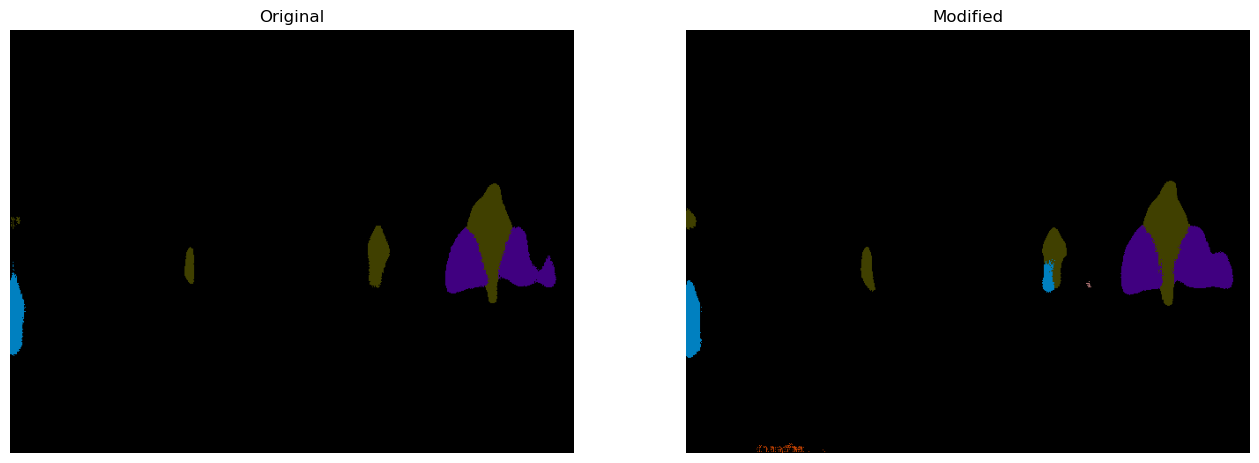

In [10]:
import matplotlib.pyplot as plt
pic = "1500D"
# 指定图像路径（例如测试集中的第一张图像）
image_path = 'runs/Predict_RTFNET_152_0{}.png'.format(pic)  # 根据实际路径调整
image_path1 = 'runs/Pred_RTFNet_152_0{}.png'.format(pic)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.title("Original")
plt.subplot(1, 2, 2)
img1 = plt.imread(image_path1)
plt.imshow(img1)
plt.axis('off')  # 隐藏坐标轴
plt.title("Modified")
plt.show()